In [1]:
import pandas as pd
import numpy as np
import ivolatility as ivol
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

<h3><u>1) SPY 1-Month Option Chain Data Collection — April 9, 2025</u>

In [2]:
start_date = "2025-04-09"
one_day_before = "2025-04-08"
ticker = "SPY"
duartion = 30

moneyness = 5
call_moneyness = 1.05
put_moneyness = 0.95

In [3]:
def get_eod_option_series(
    symbol: str,
    trade_date: str,
    dte_from: int,
    dte_to: int,
    moneyness_from: float,
    moneyness_to: float,
    call_put: str,
    save_path: str = None
) -> pd.DataFrame:
    """
    Retrieve end-of-day option data for a given symbol and trade date
    from the IVolatility API using the /equities/eod/stock-opts-by-param
    endpoint, filtered by DTE, moneyness, and option type.

    Parameters
    ----------
    symbol : str
        Ticker symbol (e.g., "SPY").
    trade_date : str
        The trading date in "YYYY-MM-DD" format.
    dte_from : int
        Minimum days to expiration.
    dte_to : int
        Maximum days to expiration.
    moneyness_from : float
        Minimum moneyness.
    moneyness_to : float
        Maximum moneyness.
    call_put : str
        "C" for calls, "P" for puts.
    save_path : str, optional
        File path to save the returned DataFrame. If provided, the data will be
        written to a CSV file at this path. If None (default), the data will
        not be saved.
    Returns
    -------
    pd.DataFrame
        DataFrame containing filtered option series data.
    """

    # Load API key
    api_key = os.getenv("API_KEY")
    if not api_key:
        raise ValueError("Environment variable 'API_KEY' is not set.")

    # Authenticate
    ivol.setLoginParams(apiKey=api_key)

    # Prepare endpoint
    getMarketData = ivol.setMethod('/equities/eod/stock-opts-by-param')

    # Query API
    df = getMarketData(
        symbol=symbol,
        tradeDate=trade_date,
        dteFrom=dte_from,
        dteTo=dte_to,
        moneynessFrom=moneyness_from,
        moneynessTo=moneyness_to,
        cp=call_put
    )

    if save_path:
        df.to_csv(save_path)

    return df


In [4]:
save_path = f"../data/Option/eod_call_option_{ticker}_{start_date}.csv"

df_call = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=duartion,
    dte_to=duartion,
    moneyness_from=-100,
    moneyness_to=100,
    call_put="C",
    save_path=save_path
)

df_call

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-04-09,SPY 250509C00300000,30,627,2025-05-09,C,300.0,198.34,198.34,198.34,...,0.000224,-0.113122,0.055141,0.238799,246.57,243.12,543.37,-44.79,138169205,0
1,2025-04-09,SPY 250509C00305000,30,627,2025-05-09,C,305.0,195.95,195.95,195.95,...,0.000244,-0.119018,0.059110,0.242318,241.74,238.12,543.37,-43.87,138169207,0
2,2025-04-09,SPY 250509C00310000,30,627,2025-05-09,C,310.0,NaN,NaN,NaN,...,0.000263,-0.123925,0.062721,0.245885,236.84,233.17,543.37,-42.95,138169209,0
3,2025-04-09,SPY 250509C00315000,30,627,2025-05-09,C,315.0,NaN,NaN,NaN,...,0.000244,-0.105663,0.054542,0.251238,231.50,228.11,543.37,-42.03,138169211,0
4,2025-04-09,SPY 250509C00320000,30,627,2025-05-09,C,320.0,NaN,NaN,NaN,...,0.000280,-0.119192,0.062859,0.254106,226.68,223.28,543.37,-41.11,138169213,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-09,SPY 250509C00630000,30,627,2025-05-09,C,630.0,NaN,NaN,NaN,...,0.000749,-0.014068,0.038542,0.004020,0.13,0.07,543.37,15.94,137973709,0
136,2025-04-09,SPY 250509C00635000,30,627,2025-05-09,C,635.0,0.06,0.11,0.06,...,0.000673,-0.013706,0.036099,0.003728,0.12,0.05,543.37,16.86,137973711,0
137,2025-04-09,SPY 250509C00640000,30,627,2025-05-09,C,640.0,0.03,0.05,0.03,...,0.000611,-0.013426,0.034044,0.003485,0.12,0.05,543.37,17.78,137973713,0
138,2025-04-09,SPY 250509C00645000,30,627,2025-05-09,C,645.0,0.03,0.03,0.03,...,0.000558,-0.013216,0.032307,0.003281,0.11,0.07,543.37,18.70,137973715,0


In [5]:
save_path = f"../data/option/eod_put_option_{ticker}_{start_date}.csv"

df_put = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=duartion,
    dte_to=duartion,
    moneyness_from=-100,
    moneyness_to=100,
    call_put="P",
    save_path=save_path
)

df_put

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-04-09,SPY 250509P00300000,30,627,2025-05-09,P,300.0,0.98,0.98,0.17,...,0.000109,-0.031580,0.022532,-0.002419,0.25,0.20,543.37,44.79,138169206,0
1,2025-04-09,SPY 250509P00305000,30,627,2025-05-09,P,305.0,0.84,1.04,0.31,...,0.000121,-0.033753,0.024468,-0.002652,0.27,0.22,543.37,43.87,138169208,0
2,2025-04-09,SPY 250509P00310000,30,627,2025-05-09,P,310.0,1.09,1.09,0.31,...,0.000131,-0.035309,0.026089,-0.002848,0.29,0.23,543.37,42.95,138169210,0
3,2025-04-09,SPY 250509P00315000,30,627,2025-05-09,P,315.0,1.12,1.18,0.33,...,0.000147,-0.038463,0.028794,-0.003183,0.32,0.26,543.37,42.03,138169212,0
4,2025-04-09,SPY 250509P00320000,30,627,2025-05-09,P,320.0,1.25,1.30,0.19,...,0.000167,-0.043090,0.032533,-0.003657,0.39,0.28,543.37,41.11,138169214,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-09,SPY 250509P00630000,30,627,2025-05-09,P,630.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,87.95,84.64,543.37,-15.94,137973710,0
136,2025-04-09,SPY 250509P00635000,30,627,2025-05-09,P,635.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,92.95,89.64,543.37,-16.86,137973712,0
137,2025-04-09,SPY 250509P00640000,30,627,2025-05-09,P,640.0,106.00,110.00,106.00,...,0.000000,0.000000,0.000000,0.000000,97.95,94.64,543.37,-17.78,137973714,0
138,2025-04-09,SPY 250509P00645000,30,627,2025-05-09,P,645.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,102.95,99.64,543.37,-18.70,137973716,0


In [6]:
df_call_five_percent = df_call[(df_call['calc_OTM'] > 5) & (df_call['calc_OTM'] < 5.5)]
df_call_five_percent

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
110,2025-04-09,SPY 250509C00571000,30,627,2025-05-09,C,571.0,1.08,5.05,0.89,...,0.009197,-0.176452,0.470783,0.098448,4.43,4.02,543.37,5.08,137937929,0
111,2025-04-09,SPY 250509C00572000,30,627,2025-05-09,C,572.0,1.00,4.66,0.84,...,0.008984,-0.173608,0.461797,0.095179,4.38,3.74,543.37,5.27,137937931,0
112,2025-04-09,SPY 250509C00572500,30,627,2025-05-09,C,572.5,1.10,3.63,0.89,...,0.008925,-0.167681,0.452360,0.091916,4.00,3.65,543.37,5.36,137937933,0
113,2025-04-09,SPY 250509C00573000,30,627,2025-05-09,C,573.0,0.94,3.96,0.77,...,0.008832,-0.164510,0.445791,0.089688,3.87,3.51,543.37,5.45,137937935,0


In [7]:
df_put_five_percent = df_put[(df_put['calc_OTM'] > 5) & (df_put['calc_OTM'] < 5.5)]
df_put_five_percent

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
50,2025-04-09,SPY 250509P00514000,30,627,2025-05-09,P,514.0,26.93,26.93,7.38,...,0.006327,-0.259627,0.509862,-0.106732,8.24,7.88,543.37,5.41,138102020,0
51,2025-04-09,SPY 250509P00515000,30,627,2025-05-09,P,515.0,33.68,34.56,7.44,...,0.006436,-0.260834,0.510681,-0.109063,8.46,8.06,543.37,5.22,137973690,0
52,2025-04-09,SPY 250509P00516000,30,627,2025-05-09,P,516.0,33.89,33.89,7.75,...,0.006544,-0.262369,0.511510,-0.111529,8.71,8.24,543.37,5.04,138102022,0


In [8]:
#Check that the underlying price of the asset is the same provided by the option chain api
print(len(list(set(df_put['underlying_price']) & set(df_call['underlying_price']))))
spot_today = list(set(df_put['underlying_price']) & set(df_call['underlying_price']))[0]
spot_today

1


543.37

In [9]:
dfs = [df_call_five_percent, df_put_five_percent]

#Take the row from each df with the smallest cal_OTM closest to 5%
smallest_rows = [df.loc[df["calc_OTM"].idxmin()] for df in dfs]

# combine into one DataFrame
df_option_five_percent_otm = pd.DataFrame(smallest_rows)
df_option_five_percent_otm.to_csv("../data/Option/eod_option_5%_OTM.csv", index=False)

df_option_five_percent_otm

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
110,2025-04-09,SPY 250509C00571000,30,627,2025-05-09,C,571.0,1.08,5.05,0.89,...,0.009197,-0.176452,0.470783,0.098448,4.43,4.02,543.37,5.08,137937929,0
52,2025-04-09,SPY 250509P00516000,30,627,2025-05-09,P,516.0,33.89,33.89,7.75,...,0.006544,-0.262369,0.511510,-0.111529,8.71,8.24,543.37,5.04,138102022,0



Based on the options data API endpoint, As of 2025/04/09 EOD, the underlying SPY price was 543.37.
the closest 1-month 5% Out-of-the-Money (OTM) options expiring on 2025/05/09 strike prices were:
- **Call:** Strike 571.0, which is 5.08% OTM.
- **Put:** Strike 516.0, which is 5.04% OTM.

We will work with these two 5% OTM options in the future analysis.

In [10]:
df_option_combined = pd.concat([df_call, df_put], ignore_index=True)

df_option_combined = df_option_combined.sort_values(
    by=["price_strike", "call_put"]
).reset_index(drop=True)

df_option_combined

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-04-09,SPY 250509C00300000,30,627,2025-05-09,C,300.0,198.34,198.34,198.34,...,0.000224,-0.113122,0.055141,0.238799,246.57,243.12,543.37,-44.79,138169205,0
1,2025-04-09,SPY 250509P00300000,30,627,2025-05-09,P,300.0,0.98,0.98,0.17,...,0.000109,-0.031580,0.022532,-0.002419,0.25,0.20,543.37,44.79,138169206,0
2,2025-04-09,SPY 250509C00305000,30,627,2025-05-09,C,305.0,195.95,195.95,195.95,...,0.000244,-0.119018,0.059110,0.242318,241.74,238.12,543.37,-43.87,138169207,0
3,2025-04-09,SPY 250509P00305000,30,627,2025-05-09,P,305.0,0.84,1.04,0.31,...,0.000121,-0.033753,0.024468,-0.002652,0.27,0.22,543.37,43.87,138169208,0
4,2025-04-09,SPY 250509C00310000,30,627,2025-05-09,C,310.0,NaN,NaN,NaN,...,0.000263,-0.123925,0.062721,0.245885,236.84,233.17,543.37,-42.95,138169209,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2025-04-09,SPY 250509P00640000,30,627,2025-05-09,P,640.0,106.00,110.00,106.00,...,0.000000,0.000000,0.000000,0.000000,97.95,94.64,543.37,-17.78,137973714,0
276,2025-04-09,SPY 250509C00645000,30,627,2025-05-09,C,645.0,0.03,0.03,0.03,...,0.000558,-0.013216,0.032307,0.003281,0.11,0.07,543.37,18.70,137973715,0
277,2025-04-09,SPY 250509P00645000,30,627,2025-05-09,P,645.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,102.95,99.64,543.37,-18.70,137973716,0
278,2025-04-09,SPY 250509C00650000,30,627,2025-05-09,C,650.0,0.04,0.10,0.04,...,0.000421,-0.009971,0.024398,0.002391,0.06,0.03,543.37,19.62,137973717,0


In [11]:
save_path = f"../data/option/eod_option_{ticker}_{start_date}.csv"
df_option_combined.to_csv(save_path, index=False)

<h3><u>2) Exploration of the SPY 1-Month Implied Volatility Curve for 5% OTM Calls and Puts</u>

In [12]:
def plot_iv_curve_two_df(call_df, put_df, underlying_price, date, iv_col="iv"):
    """
    Plot call and put implied volatility curves versus strike, using two DataFrames,
    and indicate the ATM level with a vertical line at the underlying price.

    Parameters
    ----------
    call_df : pd.DataFrame
        DataFrame with call option data. Must contain columns:
        - "price_strike"
        - iv_col (default "iv")
    put_df : pd.DataFrame
        DataFrame with put option data. Must contain columns:
        - "price_strike"
        - iv_col (default "iv")
    underlying_price : float
        Current underlying spot price (used as ATM marker).
    iv_col : str, optional
        Column name containing implied volatility (in decimal, e.g., 0.25).
    """

    plt.figure(figsize=(10, 6))

    # --- Plot Calls ---
    if call_df is not None and not call_df.empty:
        call_df = call_df.copy()
        plt.plot(
            call_df["price_strike"],
            call_df[iv_col] * 100,
            label="Calls",
            marker="o",
            linestyle="-",
            linewidth=2,
            markersize=5,
        )

    # --- Plot Puts ---
    if put_df is not None and not put_df.empty:
        put_df = put_df.copy()
        plt.plot(
            put_df["price_strike"],
            put_df[iv_col] * 100,
            label="Puts",
            marker="o",
            linestyle="-",
            linewidth=2,
            markersize=5,
        )

    # --- ATM marker (underlying price) ---
    if underlying_price is not None:
        plt.axvline(
            x=underlying_price,
            linestyle="--",
            linewidth=1.5,
            label=f"ATM (Spot Price)",
        )
        # Optional text annotation slightly above the bottom of the plot
        ymin, ymax = plt.ylim()
        plt.text(
            underlying_price,
            ymin + 0.02 * (ymax - ymin),
            "ATM",
            ha="center",
            va="bottom",
        )

    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility (%)")
    plt.title(f"SPY 1-Month Implied Volatility curve on on {date}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [13]:
def plot_iv_term_structure_two_df(call_df, put_df, date, dte_col ="dte", iv_col="iv"):

    plt.figure(figsize=(10, 6))

    # --- Plot Calls ---
    if call_df is not None and not call_df.empty:
        call_df = call_df.copy()
        plt.plot(
            call_df[dte_col],
            call_df[iv_col] * 100,
            label="Calls",
            marker="o",
            linestyle="-",
            linewidth=2,
            markersize=5,
        )

    # --- Plot Puts ---
    if put_df is not None and not put_df.empty:
        put_df = put_df.copy()
        plt.plot(
            put_df[dte_col],
            put_df[iv_col] * 100,
            label="Puts",
            marker="o",
            linestyle="-",
            linewidth=2,
            markersize=5,
        )

    plt.xlabel("Time to Maturity")
    plt.ylabel("Implied Volatility (%)")
    plt.title(f"SPY 1-Month Implied Volatility Term Structure on {date}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
df_call_one_day_before = get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=duartion-1,
    dte_to=duartion+1,
    moneyness_from=-100,
    moneyness_to=100,
    call_put="C",
    save_path=None
)


df_put_one_day_before = get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=duartion-1,
    dte_to=duartion+1,
    moneyness_from=-100,
    moneyness_to=100,
    call_put="P",
    save_path=save_path
)

In [15]:
#Check that the underlying price of the asset yesterday is the same provided by the option chain api
print(len(list(set(df_put_one_day_before['underlying_price']) & set(df_call_one_day_before['underlying_price']))))
spot_yst = list(set(df_put_one_day_before['underlying_price']) & set(df_call_one_day_before['underlying_price']))[0]
spot_yst

1


496.74

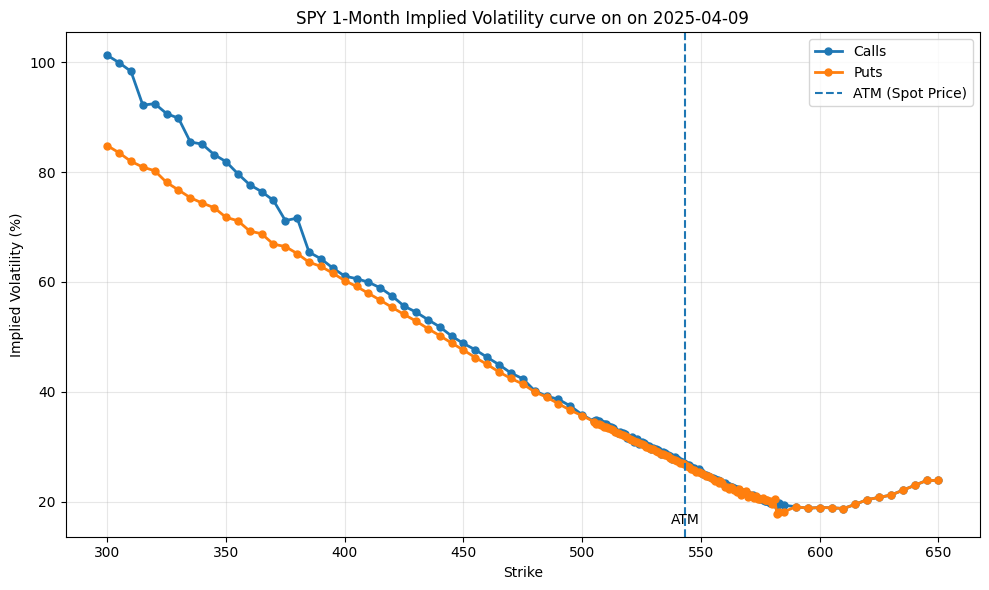

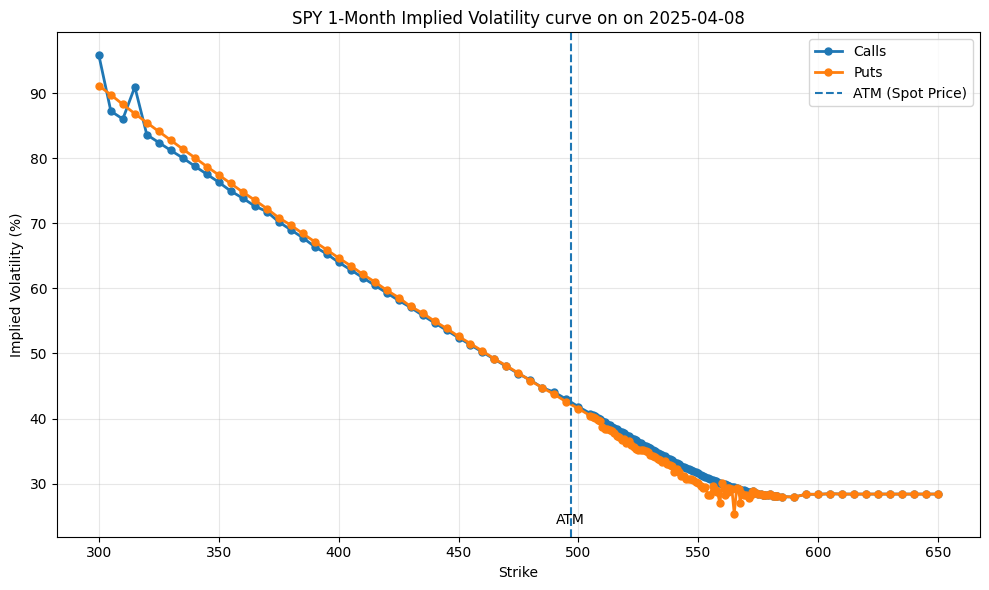

In [16]:
plot_iv_curve_two_df(df_call, df_put, spot_today, start_date)
plot_iv_curve_two_df(df_call_one_day_before, df_put_one_day_before, spot_yst, one_day_before)

From ~380 to ~650 strikes, the call and put implied volatilities track each other almost perfectly. This is as expected as the implied volatilities corresponding to put and
call options with the same strike and maturity on
the same underlying asset must be equal.
This follows from the model-independent Put–Call parity wh
ich
is satisfied by both no–arbitrage options market prices and the
Black–Scholes values of the option.


This is the highly liquid, actively traded part of the surface where put–call parity holds well, spreads are tight, and pricing is very efficient. As a result, calls and puts with the same strike/maturity give nearly identical IV.

Below ~380 strikes, the curves separate, with call IV rising noticeably above put IV.
This divergence happens because these strikes fall into the deep-in-the-money region for calls (and deep OTM for puts), where:

1) Dividends on SPY distort parity and make deep ITM calls relatively more expensive.

2) American exercise optionality matters — deep ITM calls carry early-exercise value, which breaks the clean call–put symmetry seen near ATM.

3) Liquidity drops sharply in the deep wings; wide bid–ask spreads cause small price differences to inflate IV estimates.

4) The volatility surface becomes less stable far from ATM, so IV differences appear even without true arbitrage opportunities.

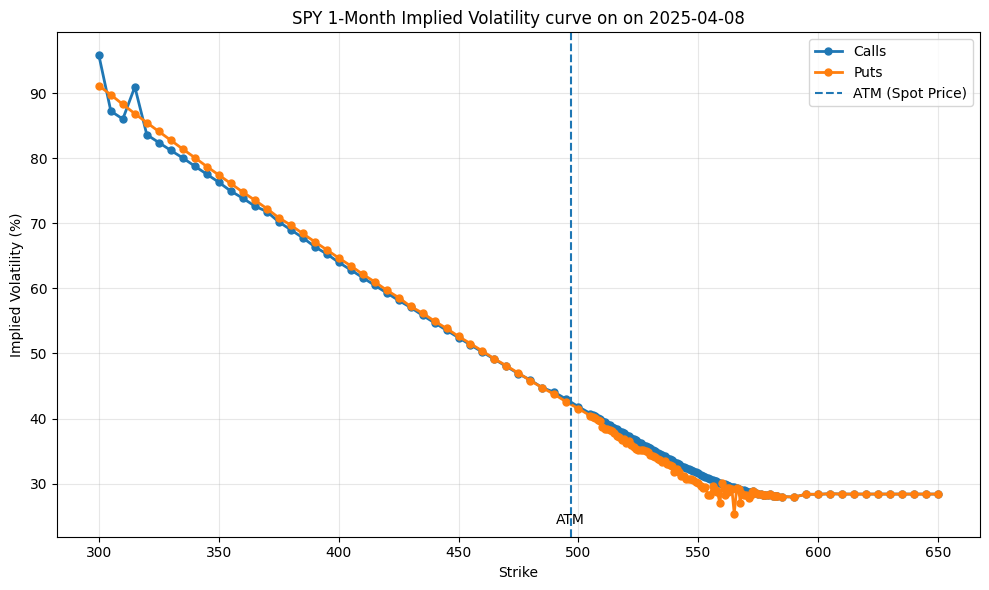

In [17]:
plot_iv_curve_two_df(df_call_one_day_before, df_put_one_day_before, spot_yst, one_day_before)

In [18]:
df_call_atm_term_structure = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=0,
    dte_to=100000,
    moneyness_from=-0.1,
    moneyness_to=0.1,
    call_put="C",
    save_path=None
)

df_put_atm_term_structure = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=0,
    dte_to=100000,
    moneyness_from=-0.1,
    moneyness_to=0.1,
    call_put="P",
    save_path=None
)

df_call_atm_term_structure_one_day_before= get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=0,
    dte_to=100000,
    moneyness_from=-0.1,
    moneyness_to=0.1,
    call_put="C",
    save_path=None
)

df_put_atm_term_structure_one_day_before= get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=0,
    dte_to=100000,
    moneyness_from=-0.1,
    moneyness_to=0.1,
    call_put="C",
    save_path=None
)

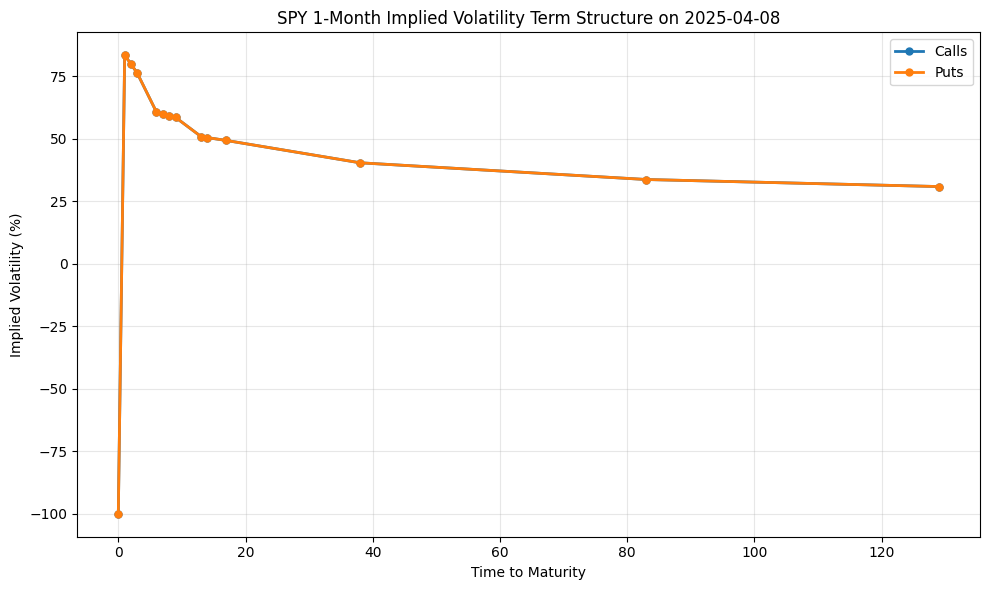

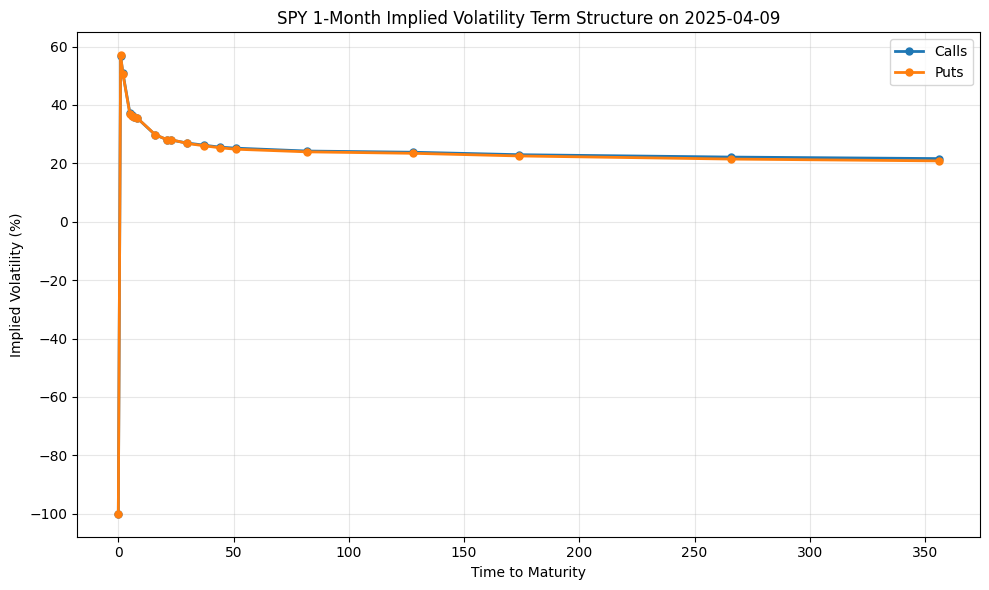

In [19]:
plot_iv_term_structure_two_df(df_call_atm_term_structure_one_day_before, df_put_atm_term_structure_one_day_before, one_day_before)
plot_iv_term_structure_two_df(df_call_atm_term_structure,df_put_atm_term_structure,start_date)

<h3><u>3) Constructing of the SPY Implied Volatility Surface</u>

In [20]:
df_call_iv_surface = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=1,
    dte_to=3000,
    moneyness_from=-1000,
    moneyness_to=1000,
    call_put="C",
    save_path=None
)

df_call_iv_surface

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-04-09,SPY 250410C00300000,1,627,2025-04-10,C,300.0,201.08,243.79,201.08,...,0.000000,0.000000,0.000000,0.008218,245.20,242.06,543.37,-44.79,138167653,0
1,2025-04-09,SPY 250410C00305000,1,627,2025-04-10,C,305.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.008355,240.20,237.06,543.37,-43.87,138167655,0
2,2025-04-09,SPY 250410C00310000,1,627,2025-04-10,C,310.0,190.81,190.81,190.81,...,0.000000,0.000000,0.000000,0.008492,235.20,232.06,543.37,-42.95,138167657,0
3,2025-04-09,SPY 250410C00315000,1,627,2025-04-10,C,315.0,185.62,185.62,185.62,...,0.000000,0.000000,0.000000,0.008629,230.25,227.06,543.37,-42.03,138167659,0
4,2025-04-09,SPY 250410C00320000,1,627,2025-04-10,C,320.0,180.01,181.16,180.01,...,0.000000,0.000000,0.000000,0.008766,225.20,222.06,543.37,-41.11,138167661,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5670,2025-04-09,SPY 271217C00895000,982,627,2027-12-17,C,895.0,NaN,NaN,NaN,...,0.000686,-0.006907,0.768668,0.537499,2.57,1.26,543.37,64.71,136409151,0
5671,2025-04-09,SPY 271217C00900000,982,627,2027-12-17,C,900.0,1.00,1.90,1.00,...,0.000658,-0.006619,0.737706,0.511304,1.95,1.62,543.37,65.63,136409153,0
5672,2025-04-09,SPY 271217C00905000,982,627,2027-12-17,C,905.0,NaN,NaN,NaN,...,0.000632,-0.006355,0.708986,0.487279,2.24,1.11,543.37,66.55,136845307,0
5673,2025-04-09,SPY 271217C00910000,982,627,2027-12-17,C,910.0,1.57,1.57,1.06,...,0.000607,-0.006100,0.681246,0.464344,2.10,1.10,543.37,67.47,136875983,0


In [21]:
df_put_iv_surface = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=1,
    dte_to=3000,
    moneyness_from=-1000,
    moneyness_to=1000,
    call_put="P",
    save_path=None
)

df_put_iv_surface

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-04-09,SPY 250410P00300000,1,627,2025-04-10,P,300.0,0.01,0.02,0.01,...,0.000000,-0.000000,0.000000,-0.000000,0.01,0.00,543.37,44.79,138167654,0
1,2025-04-09,SPY 250410P00305000,1,627,2025-04-10,P,305.0,NaN,NaN,NaN,...,0.000000,-0.000000,0.000000,-0.000000,0.01,0.00,543.37,43.87,138167656,0
2,2025-04-09,SPY 250410P00310000,1,627,2025-04-10,P,310.0,0.02,0.02,0.01,...,0.000000,-0.000000,0.000000,-0.000000,0.01,0.00,543.37,42.95,138167658,0
3,2025-04-09,SPY 250410P00315000,1,627,2025-04-10,P,315.0,NaN,NaN,NaN,...,0.000000,-0.000000,0.000000,-0.000000,0.01,0.00,543.37,42.03,138167660,0
4,2025-04-09,SPY 250410P00320000,1,627,2025-04-10,P,320.0,0.02,0.02,0.01,...,0.000000,-0.000000,0.000000,-0.000000,0.01,0.00,543.37,41.11,138167662,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5670,2025-04-09,SPY 271217P00895000,982,627,2027-12-17,P,895.0,NaN,NaN,NaN,...,0.001868,-0.003254,0.734997,-0.104169,354.00,349.47,543.37,-64.71,136409152,0
5671,2025-04-09,SPY 271217P00900000,982,627,2027-12-17,P,900.0,NaN,NaN,NaN,...,0.001849,-0.003284,0.732043,-0.104990,359.00,354.47,543.37,-65.63,136409154,0
5672,2025-04-09,SPY 271217P00905000,982,627,2027-12-17,P,905.0,NaN,NaN,NaN,...,0.001829,-0.003302,0.728741,-0.104585,364.00,359.00,543.37,-66.55,136845308,0
5673,2025-04-09,SPY 271217P00910000,982,627,2027-12-17,P,910.0,NaN,NaN,NaN,...,0.001811,-0.003328,0.725772,-0.104990,369.00,364.47,543.37,-67.47,136875984,0


In [22]:
def plot_iv_surfaces(df_call_iv_surface, df_put_iv_surface, spot_price, as_of_date):
    """
    Plots 3D IV surfaces for call and put options.
    
    Parameters
    ----------
    df_call_iv_surface : pd.DataFrame
        Must contain columns: ['price_strike', 'expiration_date', 'iv']
    df_put_iv_surface : pd.DataFrame
        Must contain columns: ['price_strike', 'expiration_date', 'iv']
    spot_price : float
        Underlying spot price used in plot titles.
    as_of_date : str
        String date for titles, e.g. "2025/04/09"
    """

    # --- Standardize 'expiration_date' column for both DataFrames ---
    for df in [df_call_iv_surface, df_put_iv_surface]:
        if not np.issubdtype(df['expiration_date'].dtype, np.number):
            df['expiration_date'] = pd.to_datetime(df['expiration_date'])
            df['expiration_date'] = (df['expiration_date'] - df['expiration_date'].min()).dt.days

    # --- CALL IV SURFACE ---
    fig1 = plt.figure(figsize=(10, 8))
    ax1 = fig1.add_subplot(111, projection="3d")
    ax1.plot_trisurf(
        df_call_iv_surface['price_strike'],
        df_call_iv_surface['expiration_date'],
        df_call_iv_surface['iv'] * 100,
        cmap=cm.viridis,
        linewidth=0.2,
        antialiased=True
    )
    ax1.set_title(f"SPY (SPDR S&P 500 ETF) Call options IV surface on {as_of_date} (Spot: {spot_price})")
    ax1.set_xlabel("Strike Price")
    ax1.set_ylabel("Expiration (days)")
    ax1.set_zlabel("Implied Volatility", labelpad=20)
    ax1.zaxis.label.set_rotation(90)
    plt.tight_layout()
    fig1.subplots_adjust(left=0.08, right=0.95, bottom=0.07, top=0.93)
    plt.show()

    # --- PUT IV SURFACE ---
    fig2 = plt.figure(figsize=(10, 8))
    ax2 = fig2.add_subplot(111, projection="3d")
    ax2.plot_trisurf(
        df_put_iv_surface['price_strike'],
        df_put_iv_surface['expiration_date'],
        df_put_iv_surface['iv'] * 100,
        cmap=cm.coolwarm,
        linewidth=0.2,
        antialiased=True
    )
    ax2.set_title(f"SPY (SPDR S&P 500 ETF) Put options IV surface on {as_of_date} (Spot: {spot_price})")
    ax2.set_xlabel("Strike Price")
    ax2.set_ylabel("Expiration (days)")
    ax2.set_zlabel("Implied Volatility", labelpad=20)
    ax2.zaxis.label.set_rotation(90)
    plt.tight_layout()
    fig2.subplots_adjust(left=0.08, right=0.95, bottom=0.07, top=0.93)
    plt.show()

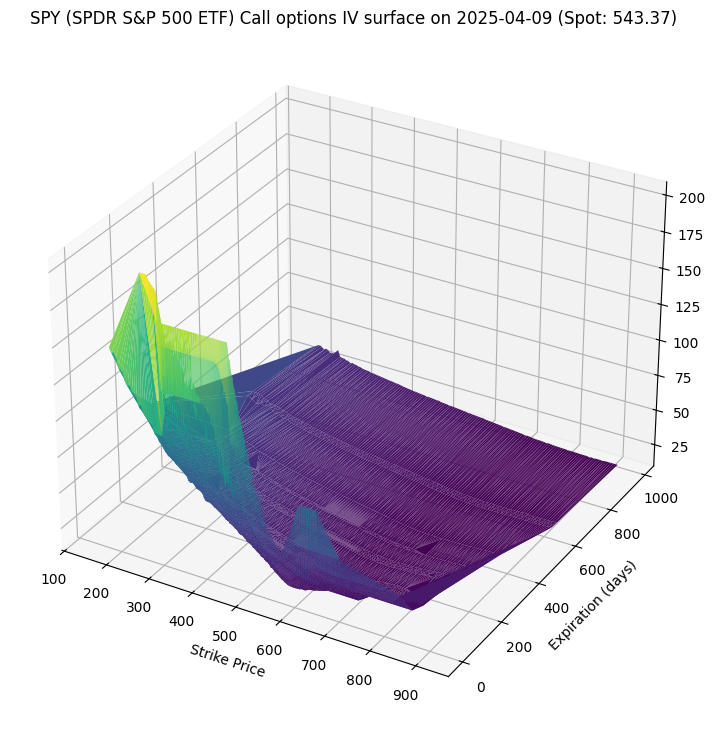

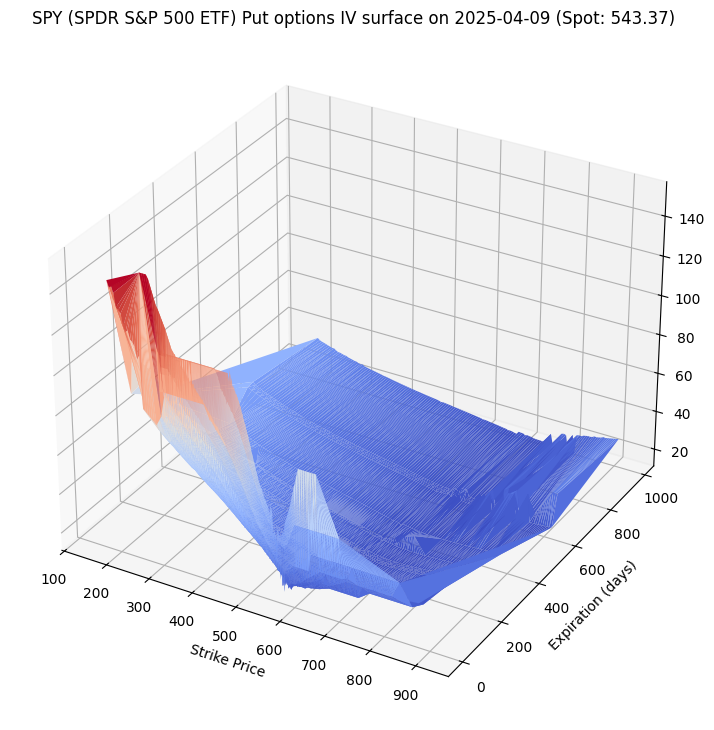

In [23]:
plot_iv_surfaces(df_call_iv_surface, df_put_iv_surface, spot_price=spot_today, as_of_date=start_date)


SPY Options IV Surface Summary (April 9, 2025)
Call Options

Peak volatility at near-term, lower strikes (~150% IV) shown in green/yellow
Decreases with longer expirations and higher strikes (settling to 50-75%)
Unusual elevation at lower strikes suggests hedging activity

Put Options

Extreme spike at near-term, low strikes (~120-140% IV) in red/orange
Classic volatility skew - investors paying premium for crash protection
Flattens with longer expirations (blue region)

Key Insights

Near-term uncertainty: Both surfaces show elevated short-dated IV
Downside protection demand: Put skew much steeper than calls
Market positioning: Active hedging against potential volatility expansion or market dislocation

In [24]:
df_call_iv_surface_one_day_before = get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=1,
    dte_to=3000,
    moneyness_from=-1000,
    moneyness_to=1000,
    call_put="C",
    save_path=None
)

df_put_iv_surface_onde_day_before = get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=1,
    dte_to=3000,
    moneyness_from=-1000,
    moneyness_to=1000,
    call_put="P",
    save_path=None
)

df_call_iv_surface_one_day_before

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-04-08,SPY 250409C00300000,1,627,2025-04-09,C,300.0,216.66,216.66,204.01,...,0.000000,-0.036265,0.000000,0.008218,198.76,194.83,496.74,-39.61,138167607,0
1,2025-04-08,SPY 250409C00305000,1,627,2025-04-09,C,305.0,NaN,NaN,NaN,...,0.000000,-0.036896,0.000001,0.008355,193.71,190.19,496.74,-38.60,138167609,0
2,2025-04-08,SPY 250409C00310000,1,627,2025-04-09,C,310.0,NaN,NaN,NaN,...,0.000000,-0.037559,0.000001,0.008492,188.82,185.08,496.74,-37.59,138167611,0
3,2025-04-08,SPY 250409C00315000,1,627,2025-04-09,C,315.0,NaN,NaN,NaN,...,0.000000,-0.038284,0.000002,0.008629,183.77,180.20,496.74,-36.59,138167613,0
4,2025-04-08,SPY 250409C00320000,1,627,2025-04-09,C,320.0,NaN,NaN,NaN,...,0.000000,-0.039128,0.000005,0.008766,178.67,175.20,496.74,-35.58,138167615,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5874,2025-04-08,SPY 271217C00895000,983,627,2027-12-17,C,895.0,1.20,1.35,1.20,...,0.000461,-0.004404,0.472920,0.303957,1.36,0.59,496.74,80.17,136409151,0
5875,2025-04-08,SPY 271217C00900000,983,627,2027-12-17,C,900.0,1.28,1.28,1.00,...,0.000441,-0.004208,0.452515,0.288566,1.16,0.90,496.74,81.18,136409153,0
5876,2025-04-08,SPY 271217C00905000,983,627,2027-12-17,C,905.0,1.25,1.25,0.98,...,0.000430,-0.004130,0.442621,0.281041,1.26,0.53,496.74,82.19,136845307,0
5877,2025-04-08,SPY 271217C00910000,983,627,2027-12-17,C,910.0,1.00,1.00,0.91,...,0.000418,-0.004055,0.433088,0.273829,1.21,0.75,496.74,83.19,136875983,0


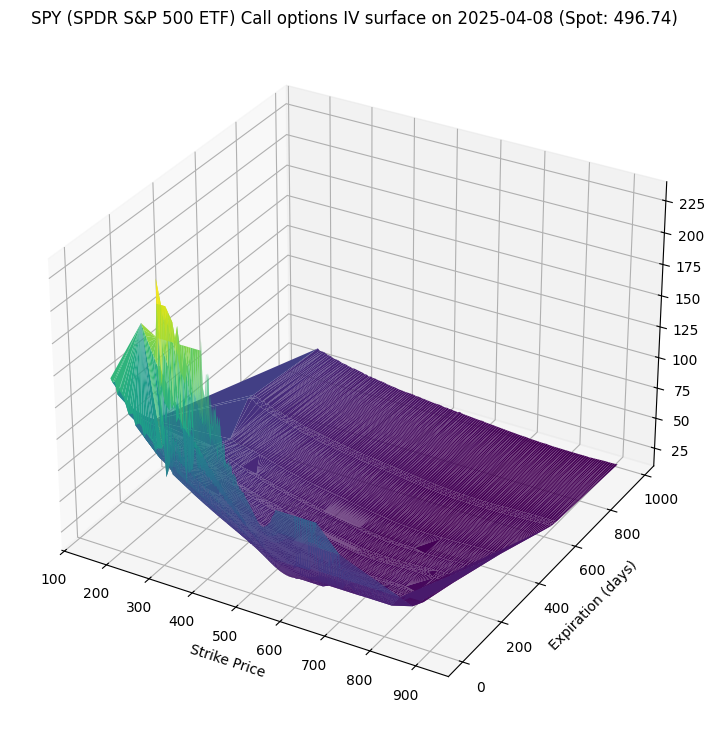

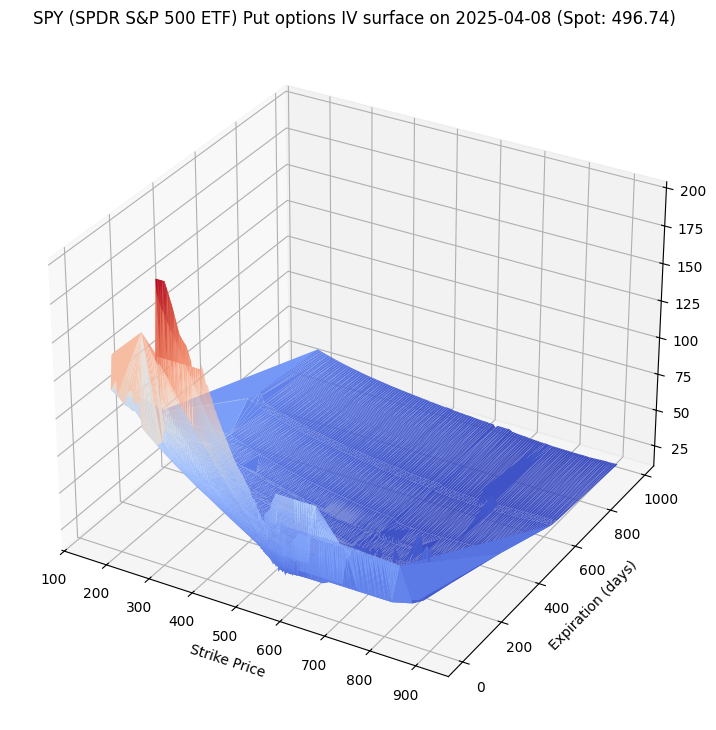

In [25]:
plot_iv_surfaces(df_call_iv_surface_one_day_before, df_put_iv_surface_onde_day_before, spot_price=spot_yst, as_of_date=one_day_before)